In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow. keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import GaussianNoise

In [16]:
# Configure GPUs for distributed training
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) < 4:
    raise RuntimeError(f"At least 4 GPUs are required, but {len(gpus)} found.")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [17]:

import pandas as pd
import numpy as np

# 文件路径
file_paths = [

    "averaged_size_30_strain22.csv",

]

# 读取数据
df_list = [pd.read_csv(file) for file in file_paths]

# 逐个增加索引
index_offset = 0
for df in df_list:
    df['index'] = df['index'] + index_offset
    index_offset += len(df['index'].unique())

# 合并数据
df_combined = pd.concat(df_list, ignore_index=False)

# 删除缺失值
df_combined.dropna(inplace=True)

# 转换数据类型为 float64
df_combined = df_combined.astype(np.float64)

# 显示前 1001 行
print(df_combined.head(1001))
df_combined.to_csv("combined_dataset.csv", index=False)




       step      strain11      strain22      strain33      strain12  \
0       0.0 -5.040000e-09 -5.700000e-09 -5.690000e-09 -3.640000e-10   
1       1.0  7.461377e-07  2.040652e-08  2.443692e-09 -3.990000e-07   
2       2.0  1.592366e-06  7.030157e-08  2.266864e-08 -8.360000e-07   
3       3.0  2.520677e-06  1.461589e-07  5.385879e-08 -1.300000e-06   
4       4.0  3.514574e-06  2.501856e-07  9.455118e-08 -1.790000e-06   
...     ...           ...           ...           ...           ...   
996   996.0  1.832180e-04  2.066940e-04  4.903175e-05  9.640994e-06   
997   997.0  1.688390e-04  1.896590e-04  4.417211e-05  8.433610e-06   
998   998.0  1.546520e-04  1.730650e-04  3.951203e-05  7.358145e-06   
999   999.0  1.407770e-04  1.570150e-04  3.505309e-05  6.403112e-06   
1000    0.0 -5.670000e-09 -5.550000e-09 -5.470000e-09  1.540465e-10   

          strain13      strain23     stress11     stress22     stress33  \
0    -3.920000e-11  5.381170e-11    -317.0653    -336.5377    -337.1342 

In [18]:
angle1 = np.genfromtxt("angle1.txt", delimiter=',')
angle2 = np.genfromtxt("angle2.txt", delimiter=',')
angle3 = np.genfromtxt("angle3.txt", delimiter=',')

In [19]:
def generateRmatrix(angle1, angle2, angle3):
    R1 = np.array([[np.cos(angle1), -np.sin(angle1), 0],[np.sin(angle1), np.cos(angle1), 0],[0, 0, 1]])
    print(R1.shape)
    R2 = np.array([[np.cos(angle2), 0, np.sin(angle2)], [0,1,0], [-np.sin(angle2), 0, np.cos(angle2)]])
    R3 = np.array([[1, 0, 0], [0, np.cos(angle3), -np.sin(angle3)], [0, np.sin(angle3), np.cos(angle3)]])
    R = np.matmul(np.matmul(R1, R2), R3)
    return R

R=generateRmatrix(angle1[0], angle2[0], angle3[0])
print(R)

(3, 3)
[[ 0.20076997  0.04246243  0.97871771]
 [-0.40057632  0.91527895  0.04246243]
 [-0.89399666 -0.40057632  0.20076997]]


In [20]:
import numpy as np


sequence_length = 1000  # 每个序列的时间步
input_n_features = 6
output_n_features = 6

input_columns = ["strain11", "strain22", "strain33", "strain12", "strain13", "strain23"]
output_columns = ["stress11", "stress22", "stress33", "stress12", "stress13", "stress23"]

# 重新计算符合条件的样本数
valid_indices = df_combined['index'].unique()
count = len(valid_indices)   # 每个 index 有 3 组数据

# 初始化 X 和 y 数组
X = np.zeros((count, sequence_length, input_n_features))
y = np.zeros((count, sequence_length, output_n_features))

# 填充 X 和 y
count = 0
for i in valid_indices:
    df1 = df_combined[df_combined['index'] == i]
    df1 = df1.sort_values(by="step")  # 确保 step 顺序正确
    
    # 按 step 递增分成三组，每组取 1000 行
    for j in range(3):
        subset = df1.iloc[j * sequence_length : (j + 1) * sequence_length]
        if len(subset) == sequence_length:
            X[count] = subset[input_columns].to_numpy()
            y[count] = subset[output_columns].to_numpy()
            count += 1

# 输出最终 X, y 的形状
print(X.shape, y.shape)



(100, 1000, 6) (100, 1000, 6)


In [21]:
def make_custom_loss_batch(model, X_batch):
    def custom_loss(y_true, y_pred):
        # Convert R to a TensorFlow constant
        R_tensor = tf.constant(R, dtype=tf.float32)
        strain = tf.cast(X_batch, dtype=tf.float32)
        
        # print(R_tensor.shape, strain.shape)

        # Extract the diagonal strain components from the first three features
        diagonal_strain = strain[:, :, :3]  # Shape: (batch_size, 1000, 3)

        # Compute Term 1
        term1 = tf.reduce_mean(tf.reduce_sum(tf.square(y_pred - y_true), axis=[1, 2]))

        # Compute Term 2
        
        rotated_strain = tf.linalg.matmul(tf.reshape(diagonal_strain, (-1, 3)), R_tensor)  # shape 40, 528, 3
        #print(diagonal_strain.shape, rotated_strain.shape)
        rotated_strain = tf.reshape(rotated_strain, tf.shape(diagonal_strain))  # shape 40, 528, 3
        #print(diagonal_strain.shape, rotated_strain.shape)
        
        R_tensor_inv = tf.linalg.inv(R_tensor)  # Compute R^{b-1}
        transformed_strain = tf.linalg.matmul(tf.reshape(rotated_strain, (-1, 3)), R_tensor_inv)  # shape 40, 528, 3
        transformed_strain = tf.reshape(transformed_strain, tf.shape(rotated_strain))   # shape 40, 528, 3
        #print(rotated_strain.shape, transformed_strain.shape)

        transformed_strain_padded = tf.concat(
            [transformed_strain, tf.zeros_like(strain[:, :, 3:])], axis=-1
        )
        predicted_transformed_stress = model(transformed_strain_padded)    # shape 40, 528, 6
        #print(rotated_strain.shape, transformed_strain.shape, predicted_transformed_stress.shape)

        # Apply rotation matrix to stress
        rotated_stress = tf.linalg.matmul(tf.reshape(y_pred[:, :, :3], (-1, 3)), R_tensor)
        rotated_stress = tf.reshape(rotated_stress, tf.shape(y_pred[:, :, :3]))

        #print(predicted_transformed_stress.shape, rotated_stress.shape)
        difference = predicted_transformed_stress[:, :, :3] - rotated_stress

        
        term2 = tf.reduce_mean(tf.reduce_sum(tf.square(difference), axis=[1, 2]))

        # Compute Term 3
        # Compute delta_sigma as the difference between the current and previous strain values from the input
        strain_current = strain[:, 1:, :6]  # Current strain (batch_size, 999, 3)
        strain_previous = strain[:, :-1, :6]  # Previous strain (batch_size, 999, 3)
        #print(strain_current.shape, strain_previous.shape)
        #print(strain_previous[:1, :].shape)

        delta_sigma = tf.concat(
            [strain_previous[:, :1, :], strain_current - strain_previous], axis=1
        )
        #print(y_pred.shape, delta_sigma.shape)

        
        
        stress_dot_change = tf.reduce_sum(y_pred * delta_sigma, axis=[1, 2])
        t = 1.0
        relu_term = tf.nn.relu(-t * stress_dot_change)
        term3 = tf.reduce_mean(relu_term)
        
        print("term1",term1, "term2", term2, "term3", term3, "sum", term1+term2+term3)
       
        # return term1 + term2 + term3
        return term1+ term3

    return custom_loss

# multi-GPU training

# Train again with the best parameters

In [22]:
best_params = {'batch_size': 40, 'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_1': 0.30000000000000004, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.00308}
# best_params = {'batch_size': 56, 'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'learning_rate': 0.005737688769386706}

# Unpack the best parameters
batch_size = best_params["batch_size"]
lstm_units_1 = best_params["lstm_units_1"]
lstm_units_2 = best_params["lstm_units_2"]
dropout_1 = best_params["dropout_1"]
dropout_2 = best_params["dropout_2"]
learning_rate = best_params["learning_rate"]

In [23]:
input_shape = X.shape[0]
print(input_shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train, tf.float32), tf.cast(y_train, tf.float32))
).batch(batch_size)

l1_strength = 1e-5  # L1 penalty (encourages sparsity)
l2_strength = 1e-4  # L2 penalty (reduces large weights)

# Build the model
model = Sequential([
    GaussianNoise(0.01),
    # First BiLSTM layer with regularization
    Bidirectional(LSTM(lstm_units_1, return_sequences=True, activation='tanh',
                       kernel_regularizer=l1_l2(l1=l1_strength, l2=l2_strength)), input_shape=(input_shape, 6)),
    Dropout(dropout_1),  # Dropout to reduce overfitting

    # Second BiLSTM layer with regularization
    Bidirectional(LSTM(lstm_units_2, return_sequences=True, activation='tanh',
                       kernel_regularizer=l1_l2(l1=l1_strength, l2=l2_strength))),
    Dropout(dropout_2),

    # Fully connected layer with regularization
    Dense(6, activation='linear', kernel_regularizer=l1_l2(l1=l1_strength, l2=l2_strength))
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
model.summary()


# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


100


/data/lzz/miniconda3/envs/yuhui/lib/python3.9/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_1                │ ?                      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

term1 tf.Tensor(8083598000000000.0, shape=(), dtype=float32) term2 tf.Tensor(1.759857e-05, shape=(), dtype=float32) term3 tf.Tensor(1.5002233e-09, shape=(), dtype=float32) sum tf.Tensor(8083598000000000.0, shape=(), dtype=float32)
term1 tf.Tensor(8095792000000000.0, shape=(), dtype=float32) term2 tf.Tensor(7.2434635, shape=(), dtype=float32) term3 tf.Tensor(0.0, shape=(), dtype=float32) sum tf.Tensor(8095792000000000.0, shape=(), dtype=float32)
term1 tf.Tensor(8083597700000000.0, shape=(), dtype=float32) term2 tf.Tensor(54.69187, shape=(), dtype=float32) term3 tf.Tensor(1.5971936e-07, shape=(), dtype=float32) sum tf.Tensor(8083597700000000.0, shape=(), dtype=float32)
term1 tf.Tensor(8095790000000000.0, shape=(), dtype=float32) term2 tf.Tensor(259.95496, shape=(), dtype=float32) term3 tf.Tensor(0.0, shape=(), dtype=float32) sum tf.Tensor(8095790000000000.0, shape=(), dtype=float32)
term1 tf.Tensor(8083594000000000.0, shape=(), dtype=float32) term2 tf.Tensor(1247.9386, shape=(), dtype=fl

2025-03-06 11:08:38.084952: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


term1 tf.Tensor(8083548300000000.0, shape=(), dtype=float32) term2 tf.Tensor(149798.25, shape=(), dtype=float32) term3 tf.Tensor(8.874491e-06, shape=(), dtype=float32) sum tf.Tensor(8083548300000000.0, shape=(), dtype=float32)
term1 tf.Tensor(8095739500000000.0, shape=(), dtype=float32) term2 tf.Tensor(168659.97, shape=(), dtype=float32) term3 tf.Tensor(9.2929696e-07, shape=(), dtype=float32) sum tf.Tensor(8095739500000000.0, shape=(), dtype=float32)
term1 tf.Tensor(8083542400000000.0, shape=(), dtype=float32) term2 tf.Tensor(186765.48, shape=(), dtype=float32) term3 tf.Tensor(1.0312424e-05, shape=(), dtype=float32) sum tf.Tensor(8083542400000000.0, shape=(), dtype=float32)
term1 tf.Tensor(8095734000000000.0, shape=(), dtype=float32) term2 tf.Tensor(204092.31, shape=(), dtype=float32) term3 tf.Tensor(2.4329638e-06, shape=(), dtype=float32) sum tf.Tensor(8095734000000000.0, shape=(), dtype=float32)
term1 tf.Tensor(8083538000000000.0, shape=(), dtype=float32) term2 tf.Tensor(220824.0, sh

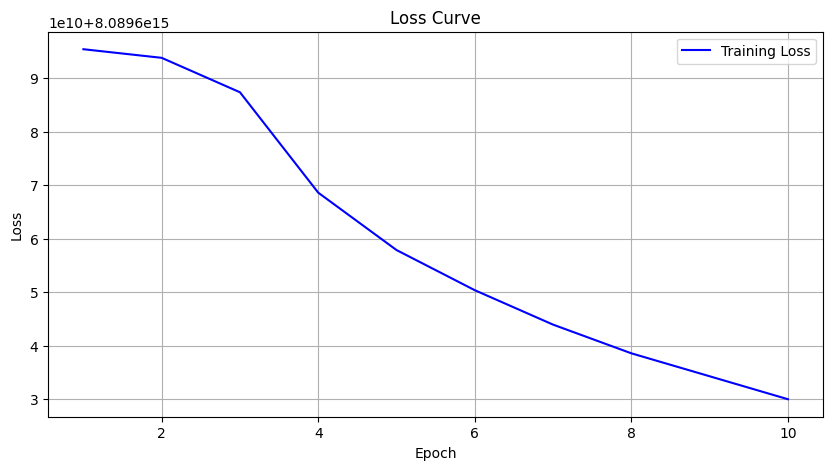

In [24]:
import matplotlib.pyplot as plt

# Track loss history
loss_history = []

# Training parameters
epochs = 10 # Keep this small for faster Optuna trials

for epoch in range(epochs):
    total_loss_epoch = 0.0  # Initialize total loss for the epoch
    batch_count = 0  # Count number of batches
    
    for X_batch, y_batch in dataset:  # Iterate over each batch
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)  # Get prediction for current batch
            loss = make_custom_loss_batch(model, X_batch)(y_batch, y_pred)  # Your custom loss function
        
        # Accumulate the loss for all batches
        total_loss_epoch += loss.numpy()  # Convert loss tensor to a float
        batch_count += 1  # Count processed batches
        
        # Calculate gradients and update weights
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # Compute average loss per epoch
    avg_loss_epoch = total_loss_epoch / batch_count
    loss_history.append(avg_loss_epoch)

# **Plot Loss Curve**
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_history, label="Training Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()
